In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [12]:
# !pip install facenet-pytorch
#%pip install matplotlib --user
%pip install scikit-learn --user

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     -------------------- ------------------- 30.7/60.8 kB 1.3 MB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 230.8 kB/s eta 0:00:00
   ---------------------------------------- 0.0/10.9 MB ? eta -:--:--
   ---------------------------------------- 0.1/10.9 MB 3.8 MB/s eta 0:00:03
   ---------------------------------------- 0.1/10.9 MB 3.8 MB/s eta 0:00:03
   -------------


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import cv2 as cv
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from facenet_pytorch import InceptionResnetV1, MTCNN

C:\Users\Mahdi\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
#img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
#plt.imshow(img) # RGB

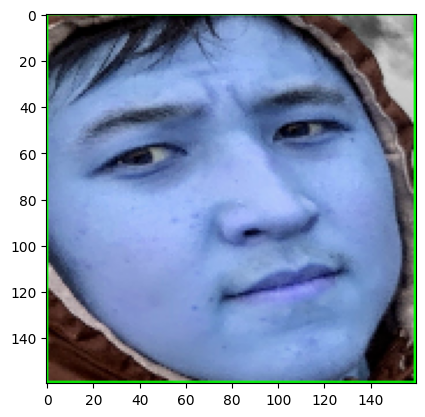

In [4]:
# Initialize the MTCNN face detector
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detector = MTCNN(keep_all=False, device=device)

# Load and preprocess the image
img = cv.imread("dataset/sardor_abdirayimov/2.png")
img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

# Detect faces
boxes, _ = detector.detect(img_rgb)

# Extract the first bounding box coordinates
if boxes is not None and len(boxes) > 0:
    x, y, w, h = [int(coord) for coord in boxes[0]]
    img_R = cv.rectangle(img_rgb, (x, y), (w, h), (0, 255, 0), 5)
    m_face = img_R[y:h, x:w]

    my_face = cv.resize(m_face, (160,160))
    # Display the image with the bounding box
    plt.imshow(cv.cvtColor(my_face, cv.COLOR_BGR2RGB))
    plt.axis('on')
    plt.show()
else:
    print("No faces detected.")

# Automate the preprocessing


In [23]:
class FACELOADING:
    def __init__(self, directory=None):
        self.directory = directory
        self.target_size = (160, 160)
        self.detector = MTCNN(keep_all=False)  # Initialize PyTorch MTCNN
        self.model = InceptionResnetV1(pretrained='vggface2').eval()  # Initialize FaceNet model
    
    def extract_face(self, filename):
        img = cv.imread(filename)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        boxes, _ = self.detector.detect(img)
        
        if boxes is not None:
            x, y, w, h = [int(v) for v in boxes[0]]  # Extract bounding box coordinates
            face = img[y:h, x:w]
            face_arr = cv.resize(face, self.target_size)
            return face_arr
        return None
    
    def get_embedding(self, face_img):
        face_tensor = torch.tensor(face_img).permute(2, 0, 1).float()  # Convert to PyTorch tensor
        face_tensor = (face_tensor - 127.5) / 128.0  # Normalize the image
        face_tensor = face_tensor.unsqueeze(0)  # Add batch dimension
        embedding = self.model(face_tensor)  # Get the embedding
        return embedding.detach().numpy()[0]  # Convert to NumPy array and remove batch dimension
    
    def process_single_image(self, filename, x):
        face_arr = self.extract_face(filename)
        if face_arr is not None:
            embedding = self.get_embedding(face_arr)
            return embedding, x
        else:
            print("No face detected.")
            return None


In [6]:
faceloading = FACELOADING("dataset")
X, Y = faceloading.process_single_image(img, name)

Loaded successfully: 10
Loaded successfully: 10
Loaded successfully: 10
Loaded successfully: 10


In [24]:
def update_npz(np_file, label, data):
    x = np.load(np_file)
    x_dict = {key: x[key] for key in x}
    x_dict[label] = data
    np.savez(np_file, **x_dict)

# Load the pretrained FaceNet model
embedder = InceptionResnetV1(pretrained='vggface2').eval()

def get_embedding(face_img):
    # Convert to float32 and normalize
    face_img = face_img.astype('float32') / 255.0  # 3D (160x160x3)

    # Convert to PyTorch tensor and add batch dimension
    face_img = torch.tensor(face_img).permute(2, 0, 1).unsqueeze(0)  # 4D (1x3x160x160)

    # Get the embedding
    with torch.no_grad():
        yhat = embedder(face_img)

    return yhat[0].numpy()  # Return the 512D embedding

def retrain_model(np_file):
    data = np.load(np_file)
    # Initialize lists to hold features and labels
    features = []
    labels = []

    # Process each key-value pair in the npz file
    for label, feature_array in data.items():
        features.append(feature_array)
        labels.extend([label] * feature_array.shape[0])
    
    # Convert lists to NumPy arrays
    features = np.vstack(features)  # Stack all feature arrays into one
    labels = np.array(labels)       # Convert labels to NumPy array

    # Encode labels to numeric values
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(labels)

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

    # Initialize and train the SVM model
    model = SVC(kernel='linear')  # You can choose other kernels if needed
    model.fit(X_train, y_train)
    with open('svm_model.pkl', 'wb') as file:
        pickle.dump(model, file)
    

def recognise(img):
    detector = MTCNN(keep_all=False)
    t_im = cv.imread(img)
    t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)

    boxes, _ = detector.detect(img)
    x, y, w, h = [int(v) for v in boxes[0]]

    t_im = t_im[y:y+h, x:x+w]
    t_im = cv.resize(t_im, (160,160))
    test_im = get_embedding(t_im)

    test_im = [test_im]
    ypreds = model.predict(test_im)
    name = encoder.inverse_transform(ypreds)[0]
    return name


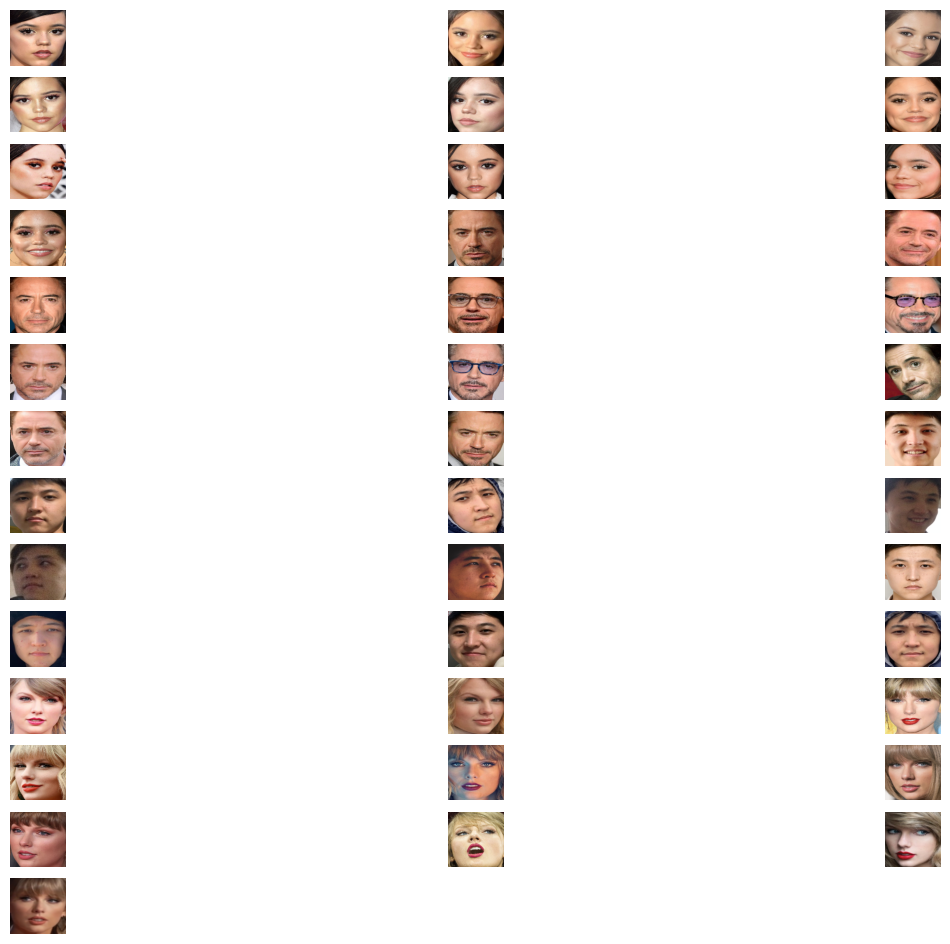

In [7]:
plt.figure(figsize=(16,12))
for num,image in enumerate(X):
    ncols = 3
    nrows = len(Y)//ncols + 1
    plt.subplot(nrows,ncols,num+1)
    plt.imshow(image)
    plt.axis('off')

# FaceNet part

In [8]:
# Load the pretrained FaceNet model
embedder = InceptionResnetV1(pretrained='vggface2').eval()

def get_embedding(face_img):
    # Convert to float32 and normalize
    face_img = face_img.astype('float32') / 255.0  # 3D (160x160x3)

    # Convert to PyTorch tensor and add batch dimension
    face_img = torch.tensor(face_img).permute(2, 0, 1).unsqueeze(0)  # 4D (1x3x160x160)

    # Get the embedding
    with torch.no_grad():
        yhat = embedder(face_img)

    return yhat[0].numpy()  # Return the 512D embedding

def retrain_model(x, y):
    model = SVC(kernel='linear', probability=True)
    model.fit(x, y)
    with open('svm_model.pkl', 'wb') as file:
        pickle.dump(model, file)

In [9]:
EMBEDDED_X = []

for img in X:
    EMBEDDED_X.append(get_embedding(img))

EMBEDDED_X = np.asarray(EMBEDDED_X)

In [10]:
np.savez_compressed('faces_embeddings.npz', EMBEDDED_X, Y)

# SVM model


In [13]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
Y = encoder.transform(Y)

Text(0, 0.5, '0')

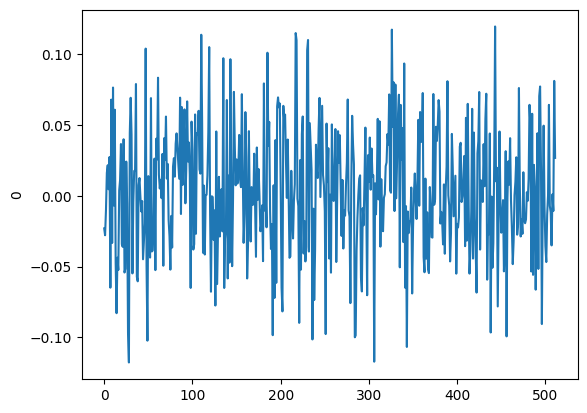

In [14]:
plt.plot(EMBEDDED_X[0])
plt.ylabel(Y[0])

In [ ]:
break

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(EMBEDDED_X, Y, shuffle=True, random_state=17)

In [16]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train, Y_train)

SVC(kernel='linear', probability=True)

In [ ]:
def retrain_model(x, y):
    model = SVC(kernel='linear', probability=True)
    model.fit(x, y)
    with open('svm_model.pkl', 'wb') as file:
        pickle.dump(model, file)

In [17]:
ypreds_train = model.predict(X_train)
ypreds_test = model.predict(X_test)

In [18]:
from sklearn.metrics import accuracy_score

accuracy_score(Y_train, ypreds_train)

1.0

In [19]:
accuracy_score(Y_test,ypreds_test)

1.0

In [20]:
t_im = cv.imread("/content/drive/MyDrive/face_recognition/sardor_test.jpg")
t_im = cv.cvtColor(t_im, cv.COLOR_BGR2RGB)
x,y,w,h = .detect_faces(t_im)[0]['box']

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


In [ ]:
t_im = t_im[y:y+h, x:x+w]
t_im = cv.resize(t_im, (160,160))
test_im = get_embedding(t_im)

In [ ]:
test_im = [test_im]
ypreds = model.predict(test_im)

In [ ]:
ypreds

In [ ]:
encoder.inverse_transform(ypreds)

In [ ]:
import pickle
#save the model
with open('svm_model_160x160.pkl','wb') as f:
    pickle.dump(model,f)

In [ ]:
def preprocessing_part()